# Multi-modal MRI Analysis
Goal : To understand data -> clean & Preprocess CSV data -> clean & preprocess MRI data  -> adapt a 3D model to predict deformation fields

In [1]:
!ls

Dev_Note.ipynb	dev_note.ipynb.amltmp  understand_data.ipynb.amltmp
data		helper


In [2]:
%cd projects/'MRI analysis'/

[Errno 2] No such file or directory: 'projects/MRI analysis/'
/mnt/batch/tasks/shared/LS_root/mounts/clusters/e4ds-v4/code/projects/MRI analysis


# Mounting data

In [3]:
from azureml.core import Workspace, Datastore
from azureml.data.dataset_factory import FileDatasetFactory

import os
import pandas as pd
import nibabel as nib

from matplotlib import pyplot as plt

In [4]:
ws = Workspace.from_config()
ds = Datastore.get(ws, datastore_name='cvdatastore')
dataset = FileDatasetFactory.from_files(path=(ds, 'Oasis/'), validate=False)
mount_path = dataset.mount()
mount_path.start()
print("Dataset mounted at: ", mount_path.mount_point)

Dataset mounted at:  /tmp/tmpttjq3iby


In [5]:
os.listdir(mount_path.mount_point)

['OAS2_RAW_PART1', 'OAS2_RAW_PART2']

In [6]:
df = pd.read_csv(
    os.path.join("data", 'oasis_longitudinal_demographics.csv')
    )

# Data Analysis

## CSV

In [7]:
len(df)

373

In [8]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [9]:
df['Group'].value_counts()

Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64

In [10]:
print("Visit counts:")
df['Visit'].value_counts()

Visit counts:


Visit
1    150
2    144
3     58
4     15
5      6
Name: count, dtype: int64

UNDERSTANIDING of DATA

So we have 373 entries, same subject Id having multiple visits (not all).
> 150 patients had visit 1

> 144 patients had vsisit 2

> 58 patients had visit 3

> 15 patients had visit 4

> 6 patients had visit 5

we only need the patients that had more than 1 visit for longitudinal imaging registration. Maybe also only consider who are diagonesed ("Demented" and "Converted")

Some of the Subjects missing a visit data

### Data cleaning & filtering

In [11]:
subject_IDs = []
for subj, grp in df.groupby('Subject ID'):
    if grp["Visit"].max() > 1:
        subject_IDs.append(subj)
len(subject_IDs)

150

As we see here, all of the patients have more than one MRI taken. i.e., all of the patients has more than 1 visit. 
that means, the data doesn't have all of the visit's MRI.

So we will narrow it down to Subjects only diagoned

In [12]:
subjects = []

for subj_id, group_df in df.groupby('Subject ID'):
    if (group_df["Group"].isin(['Demented', 'Converted']).any()):
        subjects.append(subj_id)

len(subjects)
        

78

among 150 subjects 78 subjects has been diagnosed. 
will be using all the 150 subjects for the strain map detection.

## Preprocessing the paths to images

In [13]:
paths = []
for dir in os.listdir(mount_path.mount_point):
    data_path = os.path.join(mount_path.mount_point, dir)
    print("subdir:",len(os.listdir(data_path)))
    for sub_dir in os.listdir(data_path):
        fin_path=os.path.join(data_path, sub_dir, "RAW")
        if os.path.exists(fin_path):
            paths.append(fin_path)
        else:
            print("Path does not exist:", fin_path)
print("Total MRIs: ", len(paths))
        

subdir: 209
subdir: 164
Total MRIs:  373


In [14]:
paths[0]

'/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW'

In [15]:
# we can pinpoint one example path for a subject ID using the following method
subject_IDs[0] in paths[0]

True

In [16]:
# structuring the data for easier access later
data_dict = {}
for path in paths:
    parts = path.split(os.sep)
    subj_id = parts[-2][:9]
    visit_num = parts[-2][-1]
    if subj_id not in data_dict:
        data_dict[subj_id] = {}
    data_dict[subj_id][visit_num] = path

In [17]:
data_dict["OAS2_0040"]

{'1': '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0040_MR1/RAW',
 '2': '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0040_MR2/RAW',
 '3': '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0040_MR3/RAW'}

### CSV == Images (Match Check)

In [18]:
if (df["Subject ID"].unique() == list(data_dict.keys())).all():
    print("All subject IDs match between CSV and data dictionary.")

All subject IDs match between CSV and data dictionary.


In [19]:
cnt = 0
for n in range(len(list(data_dict.keys()))):
    if len(df[df['Subject ID'] == list(data_dict.keys())[n]]) == len(data_dict[subject_IDs[n]]):
        continue
    else:
        print("Mismatch found for subject:", list(data_dict.keys())[n])
        cnt += 1

if cnt ==0:
    print("All subject IDs have matching visit counts between CSV and data dictionary.")

All subject IDs have matching visit counts between CSV and data dictionary.


In [20]:
data_dict.keys()

dict_keys(['OAS2_0001', 'OAS2_0002', 'OAS2_0004', 'OAS2_0005', 'OAS2_0007', 'OAS2_0008', 'OAS2_0009', 'OAS2_0010', 'OAS2_0012', 'OAS2_0013', 'OAS2_0014', 'OAS2_0016', 'OAS2_0017', 'OAS2_0018', 'OAS2_0020', 'OAS2_0021', 'OAS2_0022', 'OAS2_0023', 'OAS2_0026', 'OAS2_0027', 'OAS2_0028', 'OAS2_0029', 'OAS2_0030', 'OAS2_0031', 'OAS2_0032', 'OAS2_0034', 'OAS2_0035', 'OAS2_0036', 'OAS2_0037', 'OAS2_0039', 'OAS2_0040', 'OAS2_0041', 'OAS2_0042', 'OAS2_0043', 'OAS2_0044', 'OAS2_0045', 'OAS2_0046', 'OAS2_0047', 'OAS2_0048', 'OAS2_0049', 'OAS2_0050', 'OAS2_0051', 'OAS2_0052', 'OAS2_0053', 'OAS2_0054', 'OAS2_0055', 'OAS2_0056', 'OAS2_0057', 'OAS2_0058', 'OAS2_0060', 'OAS2_0061', 'OAS2_0062', 'OAS2_0063', 'OAS2_0064', 'OAS2_0066', 'OAS2_0067', 'OAS2_0068', 'OAS2_0069', 'OAS2_0070', 'OAS2_0071', 'OAS2_0073', 'OAS2_0075', 'OAS2_0076', 'OAS2_0077', 'OAS2_0078', 'OAS2_0079', 'OAS2_0080', 'OAS2_0081', 'OAS2_0085', 'OAS2_0086', 'OAS2_0087', 'OAS2_0088', 'OAS2_0089', 'OAS2_0090', 'OAS2_0091', 'OAS2_0092', '

## Images preprocessing

In [21]:
os.listdir(data_dict["OAS2_0001"]["1"])

['mpr-1.nifti.hdr',
 'mpr-1.nifti.img',
 'mpr-2.nifti.hdr',
 'mpr-2.nifti.img',
 'mpr-3.nifti.hdr',
 'mpr-3.nifti.img']

There are multiple mri in each visit, So I think running a quality check on each mri and picking the best available among each visit would be wise.

In [22]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [23]:
df["Path"] = None

for subj_id, visits in data_dict.items():
    for visit_num, path_dir in visits.items():
        df.loc[
            (df["Subject ID"] == subj_id) &
            (df["Visit"] == int(visit_num)), 
            "Path"
            ] = path_dir

In [24]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Path
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR2/RAW
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0002_MR1/RAW
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0002_MR2/RAW
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0002_MR3/RAW


In [25]:
print(f"Data Match {len(df)} == {len(df[df['Path'].notna()])}")

Data Match 373 == 373


As we are having multiple MRI's per visit, we are going to perform Quality check on each MRI and select the best among them (1 per visit)

### Selecting best MRI Per Visit

Strategy:
1. Calculate signal-to-Noise ratio (SNR), Higher the better
2. Sharpness (Laplacian Variance), Motion detection
3. Calculate Entropy (to avoid very noisy scans)

In [26]:
from helper.QC import Quality_Check as qc

In [27]:
QC = qc(df)
best_df, results = QC.pick_best()

Processing Visits..:   0%|          | 0/373 [00:00<?, ?it/s]

Processing Visits..: 100%|██████████| 373/373 [13:00<00:00,  2.09s/it]


In [28]:
from pprint import pprint

pprint(results[0], width=120, sort_dicts=False)

{'Best_scan': '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-3.nifti.img',
 'metrices': {'/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-1.nifti.img': {'snr': 9.289942681789398e-08,
                                                                                    'sharpness': 0.5745262503623962,
                                                                                    'entropy': 31.37220543556491},
              '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-2.nifti.img': {'snr': 2.1967565544400713e-07,
                                                                                    'sharpness': 0.5741432309150696,
                                                                                    'entropy': 31.487618765441773},
              '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-3.nifti.img': {'snr': 1.742154012163155e-07,
                                                                                    'sharpness': 0.5862138271

In [29]:
best_df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Path,Best
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR1/RAW,mpr-3.nifti.img
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0001_MR2/RAW,mpr-3.nifti.img
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0002_MR1/RAW,mpr-3.nifti.img
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0002_MR2/RAW,mpr-1.nifti.img
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034,/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0002_MR3/RAW,mpr-1.nifti.img


In [30]:
print(best_df.loc[372, "Best"])

mpr-1.nifti.img


This methof of filtering using SNR, Sharpness, entropy enables to pick the best MRI consistently

As we are using Azure Cloud Storage Container, The location address might change so We wont save the path into the CSV

# Visualizing images

## Image Loader

In [31]:
from helper.oasis_loader import OasisDataset

In [32]:
dataset = OasisDataset(df=best_df[best_df["Path"].notna()])
print("dataset loaded...\n\n")

dataset loaded...




In [33]:
subj = dataset["OAS2_0089"]
print(subj.visits_available())

[1, 3]


In [34]:
sample = dataset["OAS2_0089"][3]

print(sample["image"].shape)
print(sample["metadata"])

(256, 256, 128)
{'Subject ID': 'OAS2_0089', 'MRI ID': 'OAS2_0089_MR3', 'Group': 'Demented', 'Visit': 3, 'MR Delay': 563, 'M/F': 'M', 'Hand': 'R', 'Age': 72, 'EDUC': 12, 'SES': 2.0, 'MMSE': 27.0, 'CDR': 1.0, 'eTIV': 1432, 'nWBV': 0.684, 'ASF': 1.226, 'Path': '/tmp/tmpttjq3iby/OAS2_RAW_PART1/OAS2_0089_MR3/RAW', 'Best': 'mpr-1.nifti.img'}


In [35]:
sample["metadata"]["Best"]

'mpr-1.nifti.img'

## Visualizing

In [36]:
best_df["Subject ID"].unique()[0:]

array(['OAS2_0001', 'OAS2_0002', 'OAS2_0004', 'OAS2_0005', 'OAS2_0007',
       'OAS2_0008', 'OAS2_0009', 'OAS2_0010', 'OAS2_0012', 'OAS2_0013',
       'OAS2_0014', 'OAS2_0016', 'OAS2_0017', 'OAS2_0018', 'OAS2_0020',
       'OAS2_0021', 'OAS2_0022', 'OAS2_0023', 'OAS2_0026', 'OAS2_0027',
       'OAS2_0028', 'OAS2_0029', 'OAS2_0030', 'OAS2_0031', 'OAS2_0032',
       'OAS2_0034', 'OAS2_0035', 'OAS2_0036', 'OAS2_0037', 'OAS2_0039',
       'OAS2_0040', 'OAS2_0041', 'OAS2_0042', 'OAS2_0043', 'OAS2_0044',
       'OAS2_0045', 'OAS2_0046', 'OAS2_0047', 'OAS2_0048', 'OAS2_0049',
       'OAS2_0050', 'OAS2_0051', 'OAS2_0052', 'OAS2_0053', 'OAS2_0054',
       'OAS2_0055', 'OAS2_0056', 'OAS2_0057', 'OAS2_0058', 'OAS2_0060',
       'OAS2_0061', 'OAS2_0062', 'OAS2_0063', 'OAS2_0064', 'OAS2_0066',
       'OAS2_0067', 'OAS2_0068', 'OAS2_0069', 'OAS2_0070', 'OAS2_0071',
       'OAS2_0073', 'OAS2_0075', 'OAS2_0076', 'OAS2_0077', 'OAS2_0078',
       'OAS2_0079', 'OAS2_0080', 'OAS2_0081', 'OAS2_0085', 'OAS2

In [37]:
%matplotlib widget

In [38]:
from helper.mri_viewer import MultiVisitMRIViewer

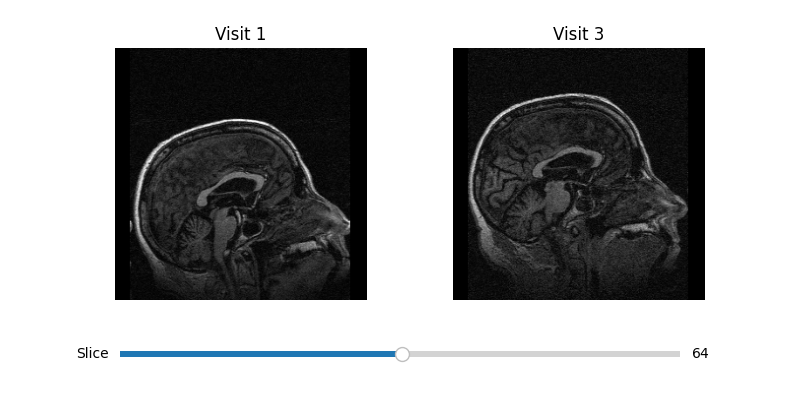

In [39]:
viewer = MultiVisitMRIViewer(dataset, "OAS2_0089")
viewer.show()

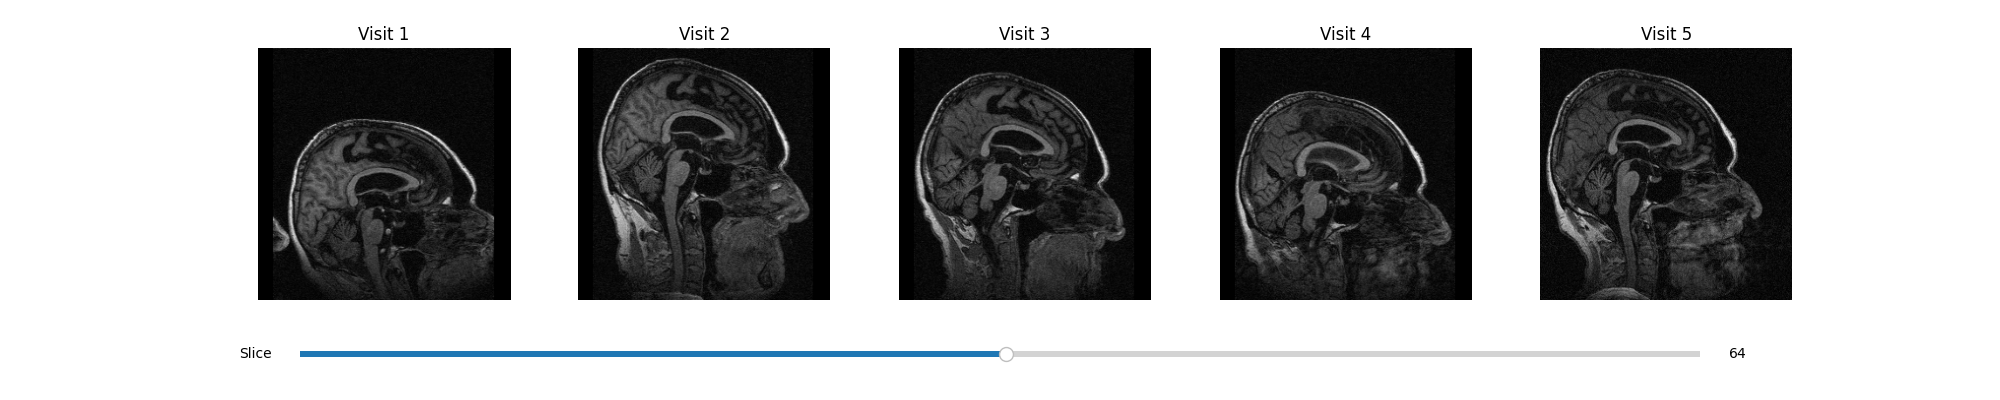

In [40]:
viewer = MultiVisitMRIViewer(dataset, "OAS2_0070")
viewer.show()
